# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_density_and_log"
    / "gls-1000g_mashr-full_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_density_and_log/gls-1000g_mashr-full_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, check_n_lvs=True, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lvs = results["lv"].unique()
    n_observed_lvs = len(observed_lvs)
    if check_n_lvs:
        assert n_observed_lvs == 1
        observed_lv = observed_lvs[0]
    else:
        observed_lv = f"All LVs ({n_observed_lvs})"

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_density_and_log/gls-1000g_mashr-full_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_density_and_log/gls-1000g_mashr-full_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_density_and_log/gls-1000g_mashr-full_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_density_and_log/gls-1000g_mashr-full_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_density_and_log/gls-1000g_mashr-full_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,-0.001444,0.007009,-0.206007,0.836792,0.581604,random.pheno988
1,LV2,0.007736,0.006552,1.180725,0.237756,0.118878,random.pheno988
2,LV3,-0.010578,0.008154,-1.297410,0.194536,0.902732,random.pheno988
3,LV4,-0.009628,0.008528,-1.128972,0.258952,0.870524,random.pheno988
4,LV5,0.001902,0.012117,0.156945,0.875293,0.437646,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.0683272543059777

# QQ-plot

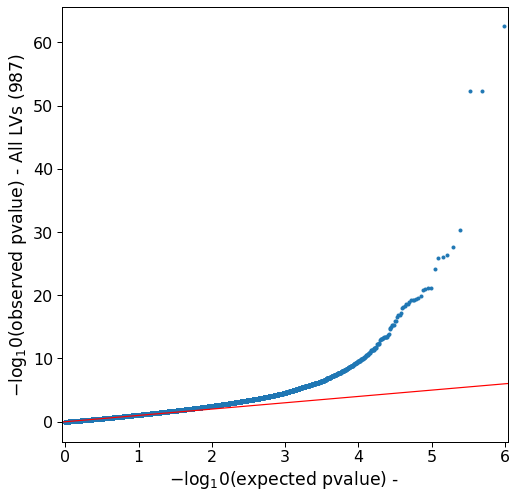

In [18]:
qqplot_unif(dfs, check_n_lvs=False)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.004,0.013,0.030
1,LV10,0.017,0.071,0.118
2,LV100,0.011,0.027,0.063
3,LV101,0.026,0.099,0.163
4,LV102,0.011,0.046,0.085


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.020977,0.068327,0.119254
std,0.020048,0.040278,0.057794
min,0.000000,0.001000,0.009000
25%,0.009000,0.043000,0.083000
50%,0.016000,0.062000,0.112000
75%,0.027000,0.087500,0.150000
max,0.245000,0.344000,0.403000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(44, 4)

,lv,1,5,10
12,LV11,0.009,0.049,0.088
336,LV401,0.015,0.049,0.088
369,LV431,0.014,0.049,0.098
245,LV32,0.012,0.049,0.101
216,LV294,0.012,0.049,0.100
296,LV366,0.015,0.049,0.095
575,LV617,0.012,0.049,0.092
320,LV388,0.008,0.049,0.076
117,LV204,0.014,0.049,0.100
821,LV839,0.010,0.049,0.110


,lv,1,5,10
332,LV399,0.011,0.050,0.091
622,LV66,0.014,0.051,0.097
629,LV666,0.010,0.051,0.105
751,LV776,0.016,0.051,0.106
779,LV800,0.011,0.051,0.111
627,LV664,0.015,0.051,0.088
435,LV491,0.007,0.051,0.105
486,LV537,0.016,0.051,0.092
478,LV53,0.011,0.051,0.110
474,LV526,0.018,0.051,0.089


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(505, 4)

,lv,1,5,10
349,LV413,0.101,0.176,0.227
24,LV120,0.093,0.183,0.251
770,LV793,0.074,0.188,0.274
960,LV964,0.072,0.190,0.282
758,LV782,0.067,0.190,0.277
632,LV669,0.067,0.191,0.294
549,LV594,0.116,0.191,0.251
401,LV460,0.100,0.192,0.248
383,LV444,0.100,0.192,0.252
965,LV969,0.061,0.193,0.317


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.010440,0.008594,1.214840,0.224472,0.112236,random.pheno988
1031,LV45,0.002805,0.008648,0.324409,0.745639,0.372819,random.pheno589
2018,LV45,0.001050,0.008574,0.122475,0.902526,0.451263,random.pheno385
3005,LV45,0.003867,0.008679,0.445613,0.655892,0.327946,random.pheno5
3992,LV45,-0.018146,0.008599,-2.110228,0.034877,0.982561,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.046

In [32]:
show_prop(results, 0.05)

0.106

In [33]:
show_prop(results, 0.10)

0.154

In [34]:
show_prop(results, 0.15)

0.201

In [35]:
show_prop(results, 0.20)

0.237

### QQplot

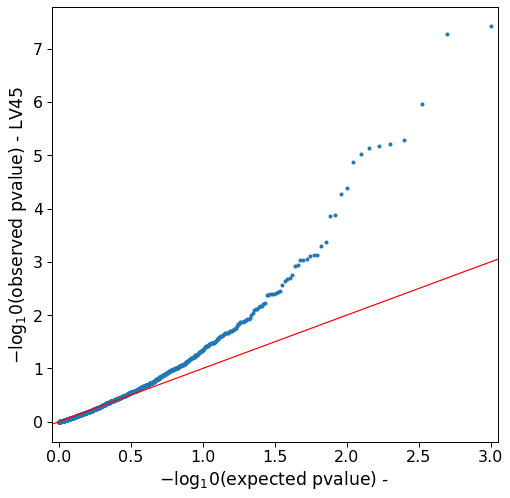

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.016356,0.010703,1.528087,0.126540,0.063270,random.pheno988
1220,LV234,0.003615,0.010772,0.335648,0.737147,0.368574,random.pheno589
2207,LV234,-0.004728,0.010680,-0.442665,0.658023,0.670988,random.pheno385
3194,LV234,0.005326,0.010810,0.492685,0.622252,0.311126,random.pheno5
4181,LV234,0.003674,0.010715,0.342856,0.731718,0.365859,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.016

In [43]:
show_prop(results, 0.05)

0.055

In [44]:
show_prop(results, 0.10)

0.103

In [45]:
show_prop(results, 0.15)

0.15

In [46]:
show_prop(results, 0.20)

0.2

### QQplot

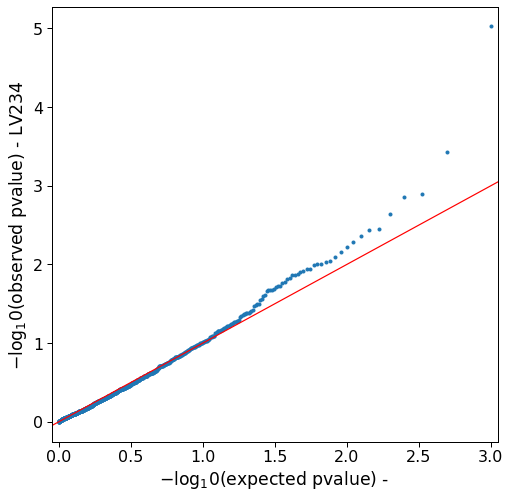

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,0.002245,0.010900,0.205955,0.836832,0.418416,random.pheno988
1833,LV847,-0.002980,0.010968,-0.271700,0.785861,0.607069,random.pheno589
2820,LV847,-0.012874,0.010873,-1.184014,0.236451,0.881774,random.pheno385
3807,LV847,-0.003753,0.011006,-0.340985,0.733126,0.633437,random.pheno5
4794,LV847,0.007039,0.010909,0.645242,0.518794,0.259397,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.008

In [54]:
show_prop(results, 0.05)

0.055

In [55]:
show_prop(results, 0.10)

0.096

In [56]:
show_prop(results, 0.15)

0.139

In [57]:
show_prop(results, 0.20)

0.178

### QQplot

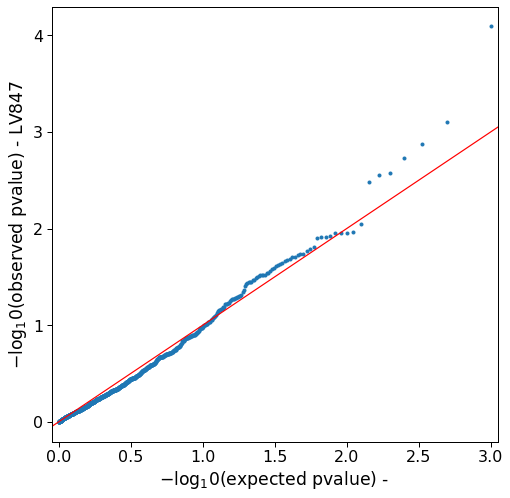

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.022677,0.008880,-2.553676,0.010682,0.994659,random.pheno988
1096,LV110,-0.012955,0.008939,-1.449389,0.147278,0.926361,random.pheno589
2083,LV110,-0.008693,0.008863,-0.980807,0.326725,0.836638,random.pheno385
3070,LV110,-0.008316,0.008971,-0.926940,0.353992,0.823004,random.pheno5
4057,LV110,0.009062,0.008892,1.019161,0.308165,0.154082,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.016

In [65]:
show_prop(results, 0.05)

0.052

In [66]:
show_prop(results, 0.10)

0.095

In [67]:
show_prop(results, 0.15)

0.142

In [68]:
show_prop(results, 0.20)

0.187

### QQplot

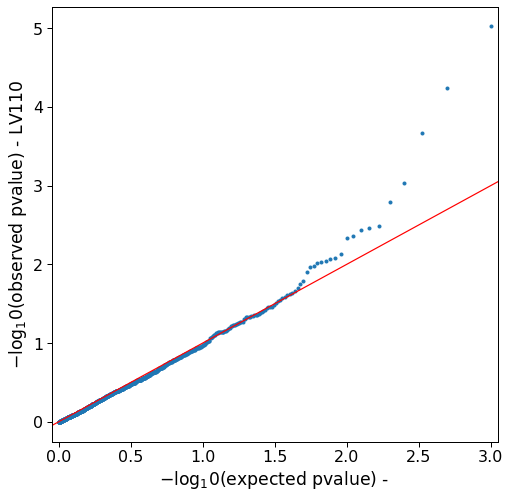

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.014347,0.010264,1.397736,0.162241,0.081120,random.pheno988
1755,LV769,-0.006994,0.010329,-0.677142,0.498340,0.750830,random.pheno589
2742,LV769,-0.010962,0.010241,-1.070431,0.284465,0.857767,random.pheno385
3729,LV769,-0.014371,0.010365,-1.386518,0.165637,0.917182,random.pheno5
4716,LV769,-0.017639,0.010272,-1.717123,0.086005,0.956998,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.06

In [76]:
show_prop(results, 0.05)

0.148

In [77]:
show_prop(results, 0.10)

0.21

In [78]:
show_prop(results, 0.15)

0.263

In [79]:
show_prop(results, 0.20)

0.323

### QQplot

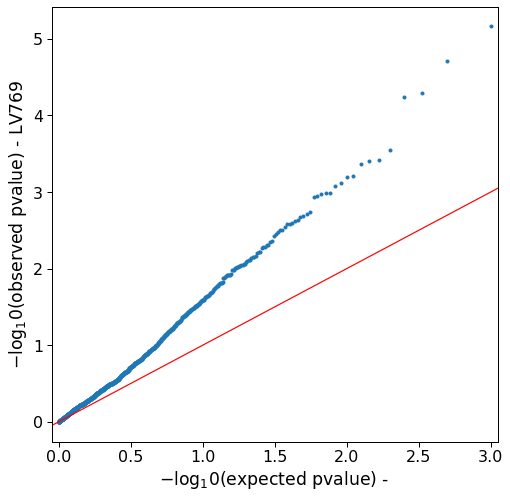

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.005110,0.012568,0.406639,0.684287,0.342143,random.pheno988
1786,LV800,-0.013201,0.012645,-1.043984,0.296532,0.851734,random.pheno589
2773,LV800,-0.003723,0.012538,-0.296951,0.766513,0.616743,random.pheno385
3760,LV800,-0.015662,0.012689,-1.234273,0.217146,0.891427,random.pheno5
4747,LV800,-0.009420,0.012578,-0.748932,0.453926,0.773037,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.011

In [87]:
show_prop(results, 0.05)

0.051

In [88]:
show_prop(results, 0.10)

0.111

In [89]:
show_prop(results, 0.15)

0.16

In [90]:
show_prop(results, 0.20)

0.205

### QQplot

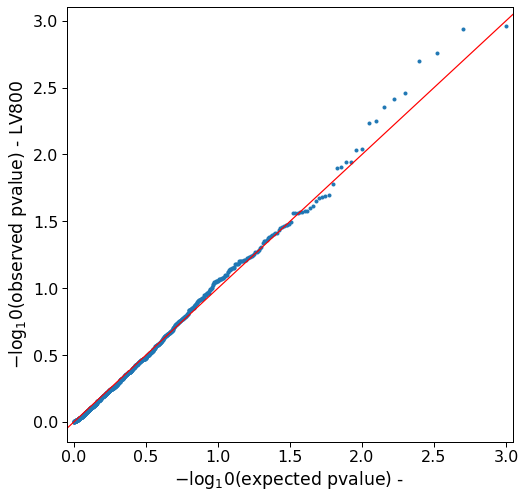

In [91]:
qqplot_unif(results)

# LVs with expected mean type I error

In [92]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
12,LV11,0.009,0.049,0.088
336,LV401,0.015,0.049,0.088
369,LV431,0.014,0.049,0.098
245,LV32,0.012,0.049,0.101
216,LV294,0.012,0.049,0.100
296,LV366,0.015,0.049,0.095
575,LV617,0.012,0.049,0.092
320,LV388,0.008,0.049,0.076
117,LV204,0.014,0.049,0.100
821,LV839,0.010,0.049,0.110


In [93]:
lv_results_expected = {}

## LV412

In [94]:
lv_code = "LV412"

In [95]:
results = dfs[dfs["lv"] == lv_code]

In [96]:
results.shape

(1000, 7)

In [97]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,0.002536,0.008885,0.285475,0.775290,0.387645,random.pheno988
1398,LV412,-0.008345,0.008940,-0.933424,0.350636,0.824682,random.pheno589
2385,LV412,0.002261,0.008864,0.255080,0.798670,0.399335,random.pheno385
3372,LV412,-0.003370,0.008972,-0.375619,0.707213,0.646394,random.pheno5
4359,LV412,0.009007,0.008891,1.013084,0.311058,0.155529,random.pheno74


In [98]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [99]:
show_prop(results, 0.01)

0.006

In [100]:
show_prop(results, 0.05)

0.015

In [101]:
show_prop(results, 0.10)

0.052

In [102]:
show_prop(results, 0.15)

0.082

In [103]:
show_prop(results, 0.20)

0.112

### QQplot

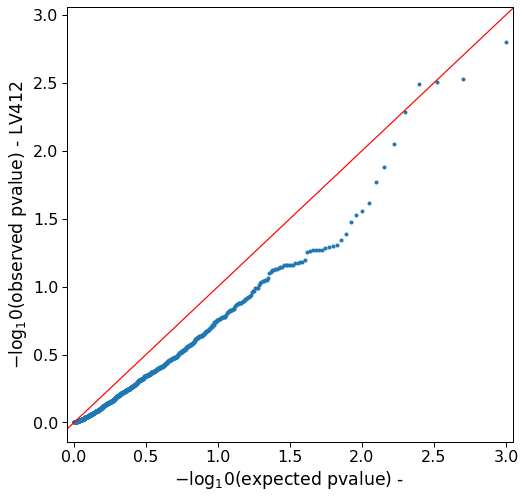

In [104]:
qqplot_unif(results)

## LV57

In [105]:
lv_code = "LV57"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.017028,0.009692,-1.756897,0.078983,0.960509,random.pheno988
1043,LV57,0.000493,0.009754,0.050534,0.959699,0.479849,random.pheno589
2030,LV57,0.020289,0.009668,2.098601,0.035891,0.017945,random.pheno385
3017,LV57,-0.003962,0.009789,-0.404791,0.685644,0.657178,random.pheno5
4004,LV57,-0.000835,0.009703,-0.086105,0.931385,0.534307,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.009

In [111]:
show_prop(results, 0.05)

0.057

In [112]:
show_prop(results, 0.10)

0.108

In [113]:
show_prop(results, 0.15)

0.155

In [114]:
show_prop(results, 0.20)

0.212

### QQplot

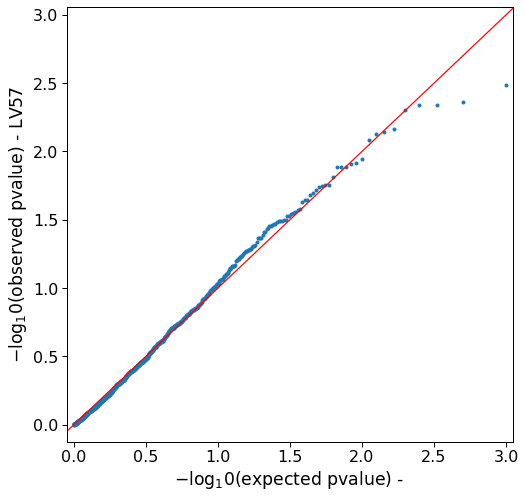

In [115]:
qqplot_unif(results)

## LV647

In [116]:
lv_code = "LV647"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.007548,0.010776,-0.700434,0.483681,0.758159,random.pheno988
1633,LV647,0.008207,0.010843,0.756916,0.449128,0.224564,random.pheno589
2620,LV647,0.012893,0.010750,1.199337,0.230441,0.115221,random.pheno385
3607,LV647,-0.000530,0.010882,-0.048713,0.961150,0.519425,random.pheno5
4594,LV647,0.018778,0.010784,1.741332,0.081673,0.040837,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.022

In [122]:
show_prop(results, 0.05)

0.076

In [123]:
show_prop(results, 0.10)

0.115

In [124]:
show_prop(results, 0.15)

0.157

In [125]:
show_prop(results, 0.20)

0.207

### QQplot

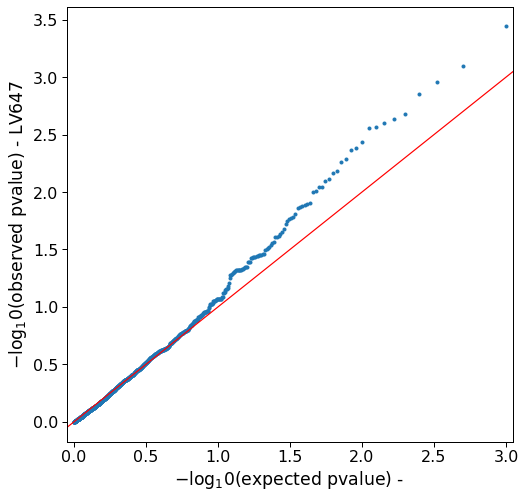

In [126]:
qqplot_unif(results)